# Linear Regression with Baseflow

In [1]:
# libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

In [2]:
# data
baseflow_raw = pd.read_csv("RRCA_baseflow.csv")
display(baseflow_raw.columns)
display(baseflow_raw.shape)

Index(['Date', 'Segment_id', 'x', 'y', 'Evapotranspiration', 'Precipitation',
       'Irrigation_pumping', 'Observed'],
      dtype='object')

(15591, 8)

## Data Cleaning

In [3]:
offset = 693595 + 368
baseflow_raw['days_since_1900'] = baseflow_raw.Date - offset
baseflow_raw['date'] = pd.to_datetime(baseflow_raw.days_since_1900.astype('int'), unit='D', origin=pd.Timestamp('1900-01-01'))
baseflow_raw['year'] = baseflow_raw.date.apply(lambda x:pd.to_datetime(x).year)
baseflow_raw['month'] = baseflow_raw.date.apply(lambda x:pd.to_datetime(x).month)
baseflow_raw['day'] = baseflow_raw.date.apply(lambda x:pd.to_datetime(x).day)

## Data Splitting

In [4]:
# split the data into training and testing sets
X = baseflow_raw.loc[:, ['day', 'month', 'year', 'Segment_id', 'x', 'y', 'Evapotranspiration', 'Precipitation', 'Irrigation_pumping']]
y = baseflow_raw.loc[:, 'Observed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)
train = pd.concat([X_train, y_train], axis=1)
train_sample = train.sample(n = 500, random_state = 42)

print("X train shape: ", X_train.shape)
print("X test shape: ", X_test.shape) 
print("y train shape: ", y_train.shape) 
print("y test shape: ", y_test.shape)
print("train shape: ", train.shape)
print("train columns: ", train.columns)
print("training random sample: ", train_sample.shape)

X train shape:  (11693, 9)
X test shape:  (3898, 9)
y train shape:  (11693,)
y test shape:  (3898,)
train shape:  (11693, 10)
train columns:  Index(['day', 'month', 'year', 'Segment_id', 'x', 'y', 'Evapotranspiration',
       'Precipitation', 'Irrigation_pumping', 'Observed'],
      dtype='object')
training random sample:  (500, 10)


## Data Exploration

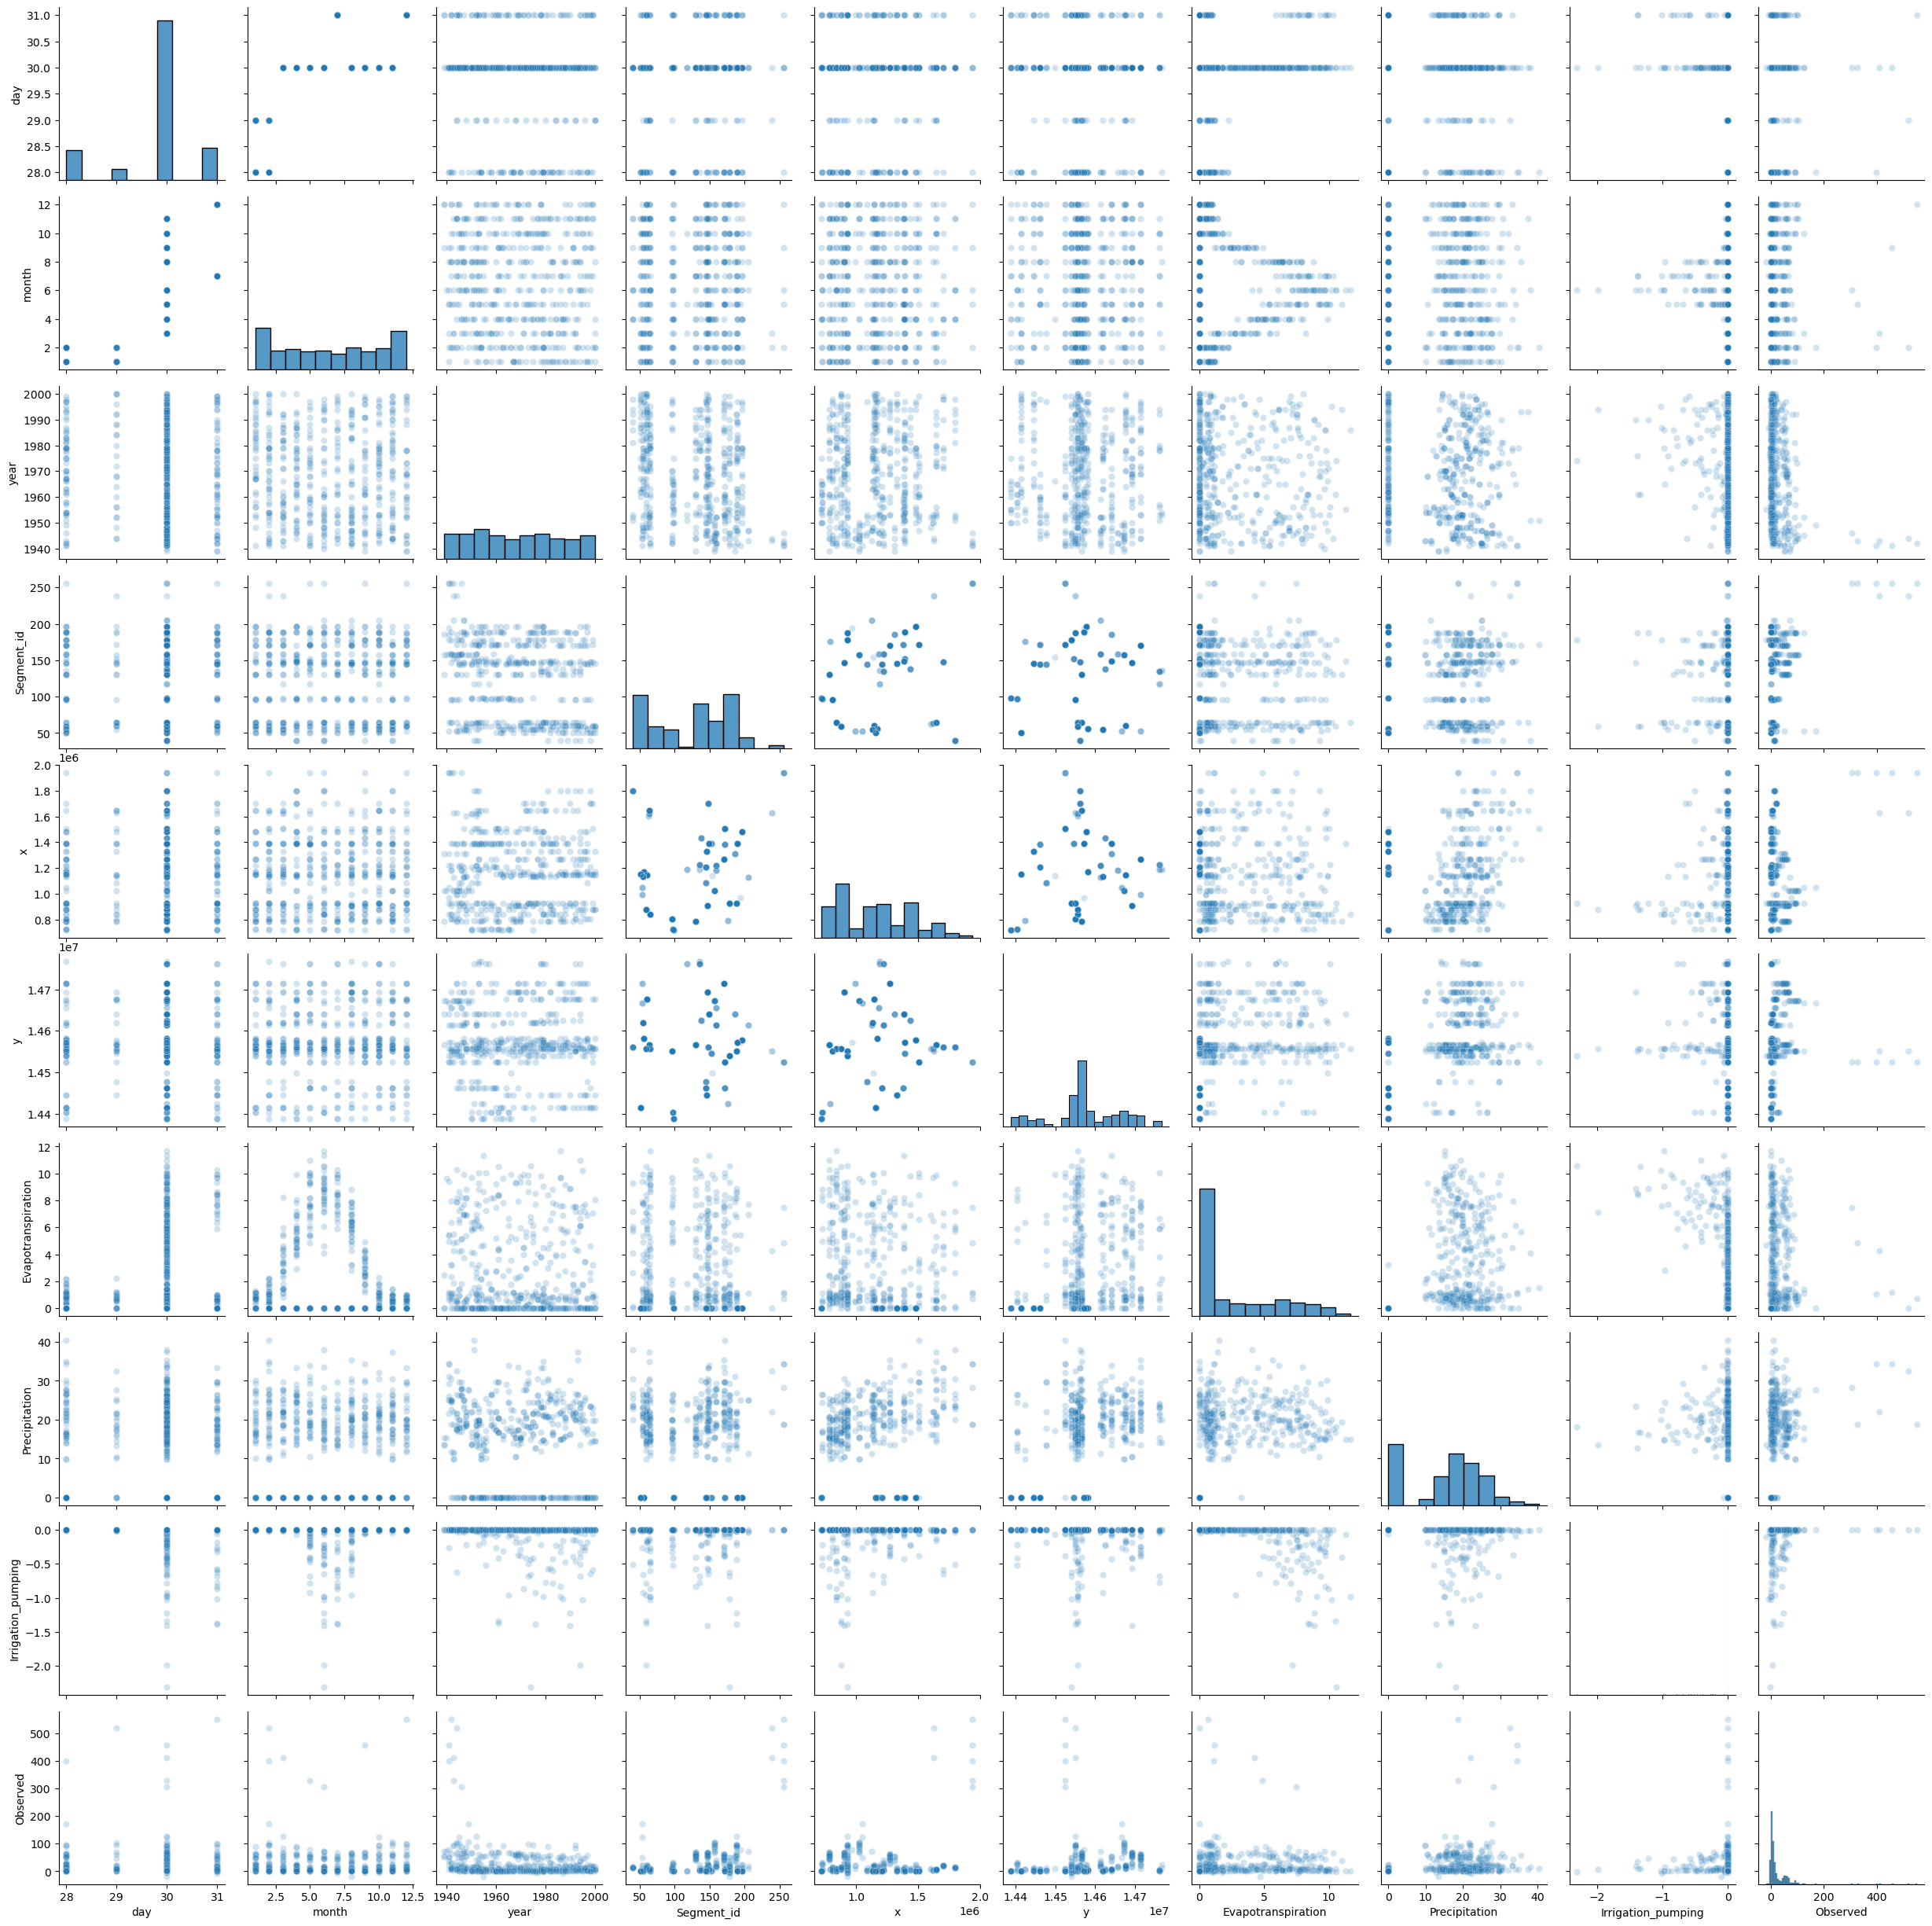

In [5]:
pairgrid = sns.PairGrid(train_sample)
pairgrid.map_diag(sns.histplot)
pairgrid.map_offdiag(sns.scatterplot, alpha = 0.2)

In [6]:
train.describe()

,day,month,year,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
count,11693.000000,11693.000000,11693.000000,11693.000000,1.169300e+04,1.169300e+04,11693.000000,11693.000000,11693.000000,11693.000000
mean,29.873343,6.454203,1968.689387,126.481827,1.168758e+06,1.457083e+07,2.710871,14.960448,-0.091530,23.988885
std,0.835485,3.453205,17.255054,52.810855,2.928869e+05,8.345995e+04,3.175613,10.470351,0.273172,56.369140
min,28.000000,1.000000,1939.000000,40.000000,7.218700e+05,1.438704e+07,0.000000,0.000000,-3.164700,-22.000000
25%,30.000000,3.000000,1953.000000,64.000000,9.066700e+05,1.454544e+07,0.000000,0.000000,-0.012000,2.003607
50%,30.000000,6.000000,1968.000000,145.000000,1.170670e+06,1.456128e+07,1.060000,17.510000,0.000000,7.730000
75%,30.000000,9.000000,1984.000000,171.000000,1.392430e+06,1.461936e+07,5.420000,22.370000,0.000000,22.750492
max,31.000000,12.000000,2000.000000,256.000000,1.941550e+06,1.476720e+07,12.100000,40.380000,0.000000,739.672130


In [7]:
train.corr()

,day,month,year,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
day,1.000000,0.682150,-0.018095,0.000891,-0.008278,-0.003546,0.241034,-0.005877,-0.177629,-0.040354
month,0.682150,1.000000,-0.025964,-0.000328,-0.002757,0.002862,-0.111787,-0.004111,-0.008048,-0.039954
year,-0.018095,-0.025964,1.000000,-0.143897,0.068082,-0.014376,-0.032792,-0.023997,-0.203429,-0.232484
Segment_id,0.000891,-0.000328,-0.143897,1.000000,0.242122,0.059185,-0.047558,-0.047188,0.062578,0.340418
x,-0.008278,-0.002757,0.068082,0.242122,1.000000,0.090277,-0.165398,-0.012998,0.126536,0.096723
y,-0.003546,0.002862,-0.014376,0.059185,0.090277,1.000000,0.232643,0.421575,-0.045906,0.099291
Evapotranspiration,0.241034,-0.111787,-0.032792,-0.047558,-0.165398,0.232643,1.000000,0.428167,-0.496158,0.059620
Precipitation,-0.005877,-0.004111,-0.023997,-0.047188,-0.012998,0.421575,0.428167,1.000000,-0.156893,0.270281
Irrigation_pumping,-0.177629,-0.008048,-0.203429,0.062578,0.126536,-0.045906,-0.496158,-0.156893,1.000000,0.053735
Observed,-0.040354,-0.039954,-0.232484,0.340418,0.096723,0.099291,0.059620,0.270281,0.053735,1.000000


### Observed

<Axes: xlabel='Observed', ylabel='Count'>

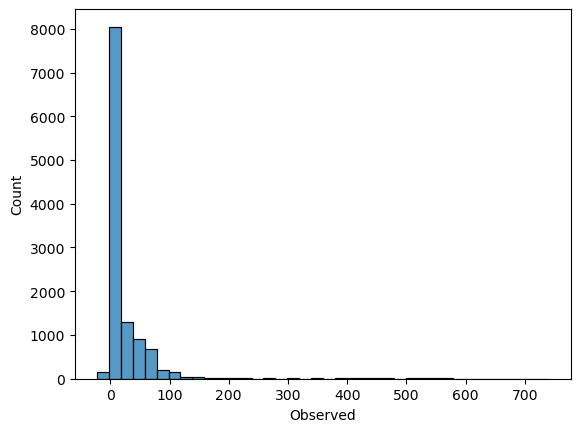

In [8]:
sns.histplot(data=train, x='Observed', binwidth=20)

<Axes: ylabel='Count'>

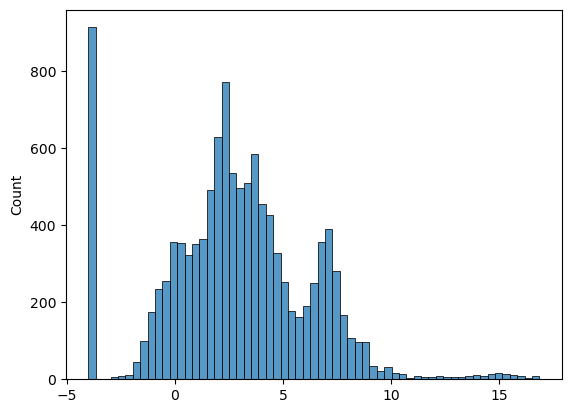

In [9]:
observed_mod = boxcox(train.Observed, 0.25)
sns.histplot(observed_mod)

### Evapotranspiration

count    11693.000000
mean         2.710871
std          3.175613
min          0.000000
25%          0.000000
50%          1.060000
75%          5.420000
max         12.100000
Name: Evapotranspiration, dtype: float64

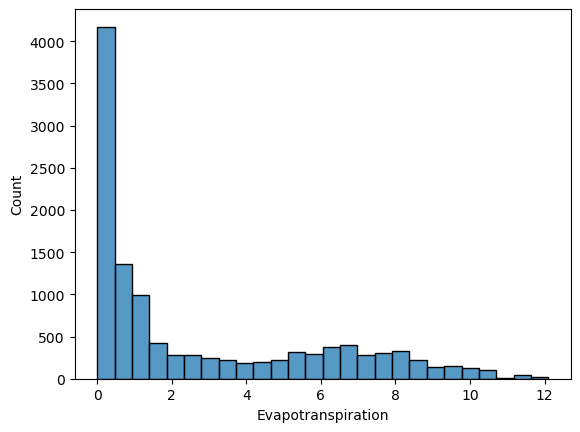

In [10]:
sns.histplot(data=train, x="Evapotranspiration")
display(train.Evapotranspiration.describe())

### Precipitation

<Axes: xlabel='Precipitation', ylabel='Count'>

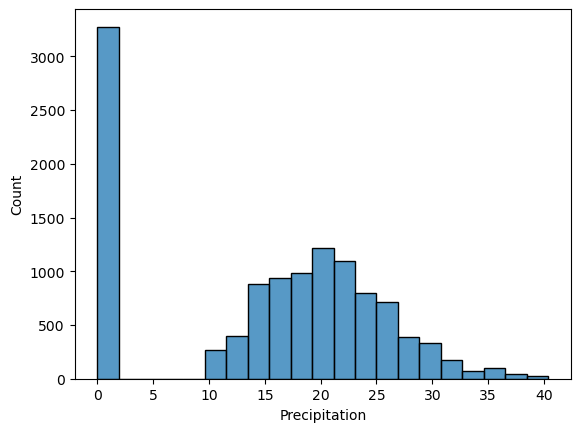

In [11]:
sns.histplot(data=train, x="Precipitation")

<Axes: xlabel='Precipitation', ylabel='Observed'>

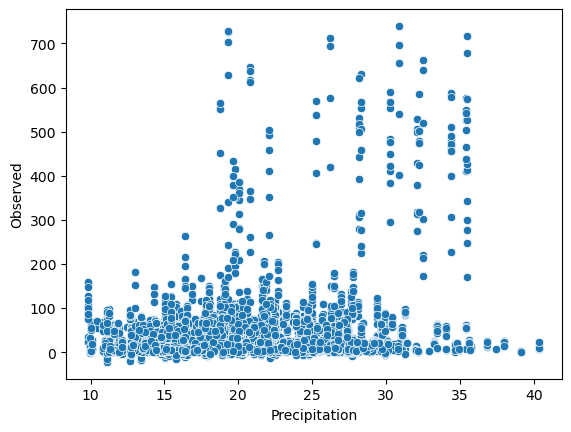

In [12]:
# scatterplot of precipitation vs observed
sns.scatterplot(data=train.loc[train.Precipitation != 0, :], x="Precipitation", y ="Observed")

<Axes: xlabel='month', ylabel='count'>

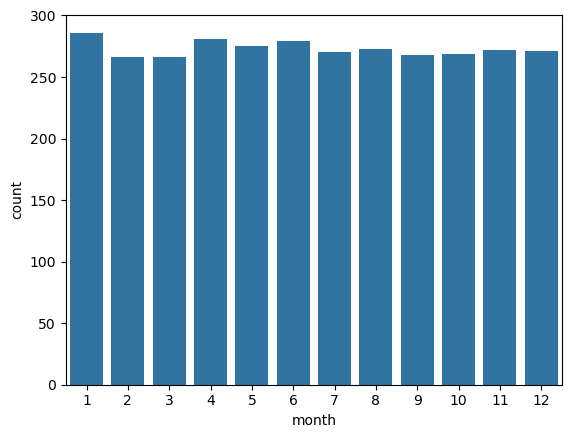

In [13]:
# months with zero precipitation
sns.countplot(data=train.loc[train.Precipitation == 0, :], x='month')

In [14]:
# pairwise plot of cases where precipitation is 0
# precipitation_0 = train.loc[train.Precipitation == 0, :]
# precipitation_0.describe()
# pairgrid = sns.PairGrid(precipitation_0.sample(n=500))
# pairgrid.map_diag(sns.histplot)
# pairgrid.map_offdiag(sns.scatterplot, alpha = 0.2)

### Month

<Axes: xlabel='month', ylabel='Observed'>

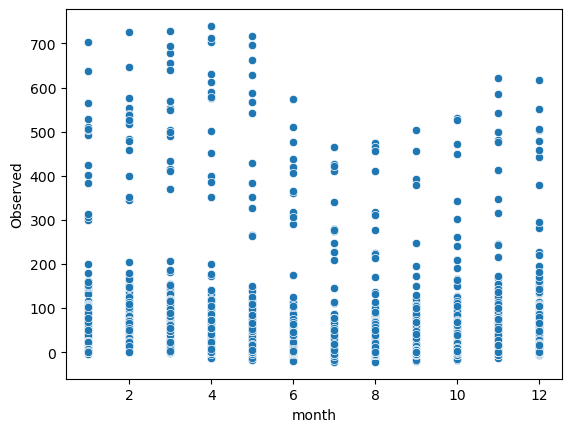

In [15]:
sns.scatterplot(data=train, x='month', y = 'Observed')

### Geographic Information

x        y         Segment_id
874990   14556000  59            559
785230   14566560  130           548
838030   14556000  65            543
1392430  14571840  189           542
806350   14550720  96            532
927790   14540160  178           527
1170670  14582400  56            488
906670   14693280  147           487
1482190  14577120  196           479
1270990  14714400  170           440
927790   14550720  188           439
1154830  14413440  51            371
1387150  14640480  149           367
1133710  14619360  55            364
1144270  14677440  60            362
1329070  14445120  146           353
1508590  14524320  171           342
1703950  14561280  148           340
1645870  14566560  64            305
1392430  14545440  152           291
1207630  14460960  145           286
721870   14387040  98            237
1798990  14561280  40            232
1223470  14761920  135           222
1434670  14624640  138           205
727150   14402880  97            194
1218190 

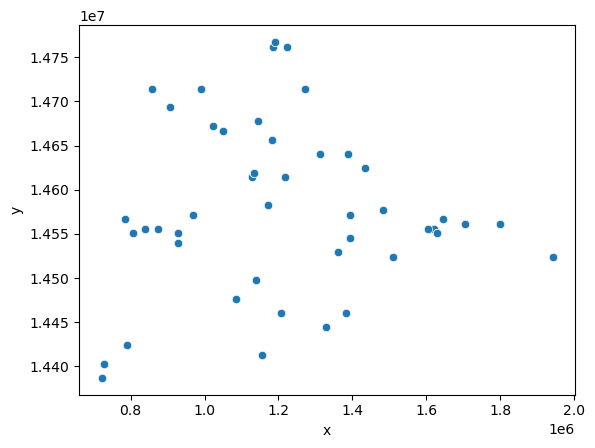

In [16]:
sns.scatterplot(train, x='x', y='y')
train.value_counts(['x', 'y', 'Segment_id'])

## Data Pre-processing

In [17]:
train_mod = train.copy()

# create a summer feature
train_mod['Summer'] = np.where((train_mod.month >= 6) & (train_mod.month <= 10), 1, 0)


# one hot encode the months
month_encoder = OneHotEncoder(sparse_output=False)
months_onehot = month_encoder.fit_transform(train_mod.loc[:, ['month']])
train_mod[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']] = months_onehot

# one hot encode the segment ids
segment_encoder = OneHotEncoder(sparse_output=False)
segments_onehot = segment_encoder.fit_transform(train_mod.loc[:, ['Segment_id']])
train_mod[segment_encoder.get_feature_names_out()] = segments_onehot


# transform Y
train_mod['Observed'] = boxcox(train_mod.Observed, 0.5)

# transform Irrigation pumping
# train_mod['Irrigation_pumping'] = boxcox(train_mod.Irrigation_pumping, -0.25)

In [18]:
# drop unnecessary columns 
train_mod = train_mod.drop(columns=['day', 'month', 'Segment_id', 'Summer']).dropna()
X_train = train_mod.drop(columns='Observed')
y_train = train_mod.loc[:, 'Observed']

In [19]:
# train_mod.head(30)
train_mod.columns
all_pred_columns = "+".join(train_mod.columns.difference(["Observed"]))
ols_formula = "Observed ~ " + all_pred_columns
ols_formula

'Observed ~ Evapotranspiration+Irrigation_pumping+Precipitation+Segment_id_118+Segment_id_123+Segment_id_130+Segment_id_135+Segment_id_136+Segment_id_138+Segment_id_144+Segment_id_145+Segment_id_146+Segment_id_147+Segment_id_148+Segment_id_149+Segment_id_152+Segment_id_154+Segment_id_157+Segment_id_159+Segment_id_170+Segment_id_171+Segment_id_176+Segment_id_178+Segment_id_186+Segment_id_188+Segment_id_189+Segment_id_194+Segment_id_196+Segment_id_205+Segment_id_239+Segment_id_256+Segment_id_40+Segment_id_51+Segment_id_53+Segment_id_55+Segment_id_56+Segment_id_59+Segment_id_60+Segment_id_62+Segment_id_63+Segment_id_64+Segment_id_65+Segment_id_96+Segment_id_97+Segment_id_98+apr+aug+dec+feb+jan+jul+jun+mar+may+nov+oct+sep+x+y+year'

## Linear Model from Stats Model

In [20]:
lm = smf.ols(formula=ols_formula, data=train_mod).fit()

In [21]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Observed   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     1585.
Date:                Fri, 25 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:33:16   Log-Likelihood:                -25441.
No. Observations:               11520   AIC:                         5.100e+04
Df Residuals:                   11461   BIC:                         5.143e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1342.9388     46.031     29.174      0.000    1252.709    1433.168
Evapotranspiration    -0.1525      0.013    -11.952      0.000      -0.177      -0.127
Irrigation_pumping     0.2947      0.106      2.789      0.005       0.088       0.502
Precipitation          0.0801      0.004     18.424      0.000       0.072       0.089
Segment_id_118        43.7204      1.797     24.333      0.000      40.198      47.242
Segment_id_123        59.0697      2.192     26.943      0.000      54.772      63.367
Segment_id_130        54.9097      1.679     32.712      0.000      51.619      58.200
Segment_id_135        45.7811      1.736     26.367      0.000      42.378      49.185
Segment_id_136        51.8996      1.802     28.794      0.000      48.367      55.433
Segment_id_138        23.4031      1.083     21.615      0.000      21.281      25.525
Segment_id_144        21.9011      0.911     24.040      0.000      20.115      23.687
Segment_id_145        13.2278      0.708     18.689      0.000      11.840      14.615
Segment_id_146         7.7904      0.582     13.378      0.000       6.649       8.932
Segment_id_147        61.6910      1.912     32.273      0.000      57.944      65.438
Segment_id_148         8.3035      0.970      8.557      0.000       6.401      10.205
Segment_id_149        26.4258      1.157     22.837      0.000      24.158      28.694
Segment_id_152        15.4055      0.862     17.873      0.000      13.716      17.095
Segment_id_154        22.0575      0.950     23.228      0.000      20.196      23.919
Segment_id_157        59.0578      1.675     35.251      0.000      55.774      62.342
Segment_id_159        36.6762      1.266     28.970      0.000      34.195      39.158
Segment_id_170        47.8252      1.513     31.610      0.000      44.860      50.791
Segment_id_171         8.1774      0.718     11.394      0.000       6.771       9.584
Segment_id_176        32.4120      1.233     26.289      0.000      29.995      34.829
Segment_id_178        37.7376      1.353     27.893      0.000      35.086      40.390
Segment_id_186        37.9489      1.227     30.919      0.000      35.543      40.355
Segment_id_188        49.7570      1.388     35.846      0.000      47.036      52.478
Segment_id_189        17.9514      0.956     18.772      0.000      16.077      19.826
Segment_id_194        51.7604      1.424     36.360      0.000      48.970      54.551
Segment_id_196        15.3845      0.953     16.135      0.000      13.516      17.254
Segment_id_205        45.0667      1.332     33.833      0.000      42.456      47.678
Segment_id_239        37.7683      0.915     41.265      0.000      35.974      39.562
Segment_id_256        23.0294      1.265     18.207      0.000      20.550      25.509
Segment_id_40          2.8309      1.0

## Variance Inflation Factors

In [22]:
# vif_data["VIF"] = [variance_inflation_factor(X.values, i)
#                           for i in range(len(X.columns))]

# features = X_train.columns
# vifs = [variance_inflation_factor(X_train, feature_idx) for feature_idx in range(X_train.shape[1])]

In [23]:
# pd.DataFrame({'Feature':features, 'VIF':vifs}).head(30)

## Inspect Residuals

In [24]:
train_pred = lm.predict(X_train)
train_resid = train_pred - y_train
residuals = pd.DataFrame({'actual':y_train, 'predicted':train_pred, 'residual':train_resid})
residuals = pd.concat([residuals, X_train], axis = 1)

<Axes: xlabel='predicted', ylabel='residual'>

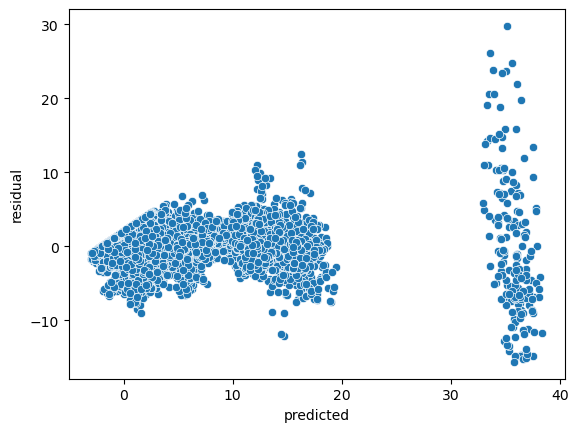

In [25]:
sns.scatterplot(data=residuals, x ='predicted', y ='residual')

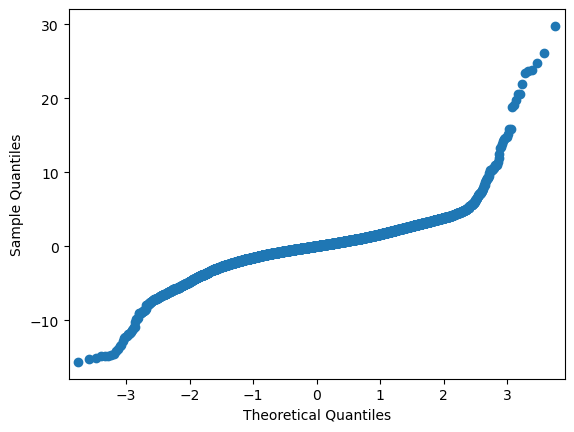

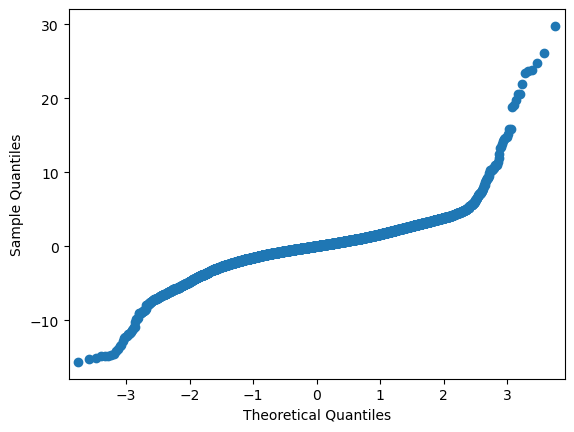

In [26]:
qqplot(residuals.residual)
# ref_line = [0, 50]
# plt.plot(ref_line, ref_line)

<Axes: xlabel='actual', ylabel='predicted'>

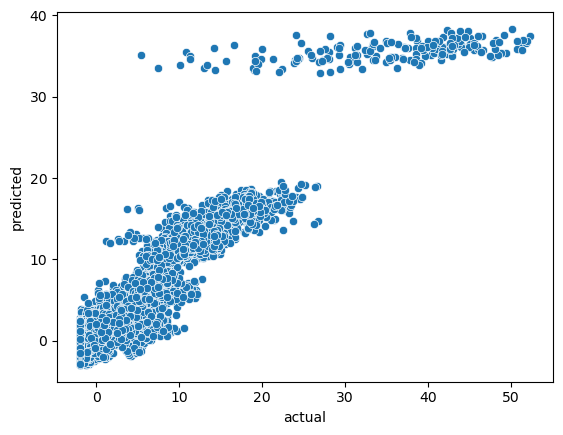

In [27]:
sns.scatterplot(data=residuals, x='actual', y='predicted')


<Axes: xlabel='Precipitation', ylabel='residual'>

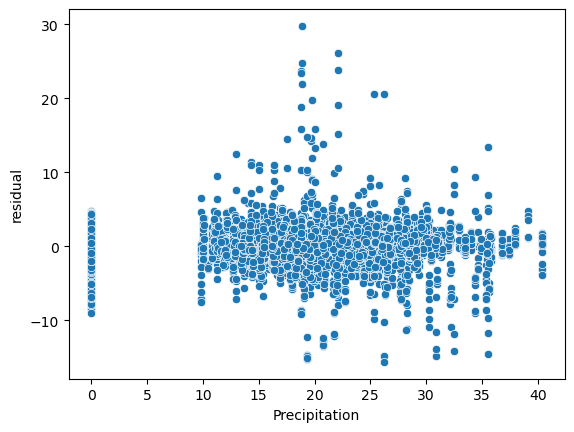

In [28]:
sns.scatterplot(data=residuals, x='Precipitation', y='residual')

<Axes: xlabel='Evapotranspiration', ylabel='residual'>

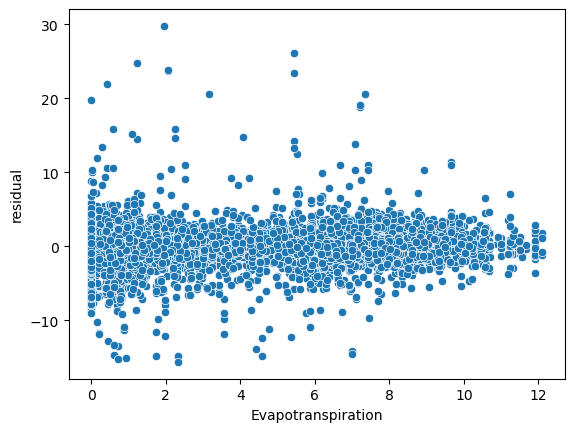

In [29]:
sns.scatterplot(data=residuals, x='Evapotranspiration', y='residual')

<Axes: xlabel='x', ylabel='residual'>

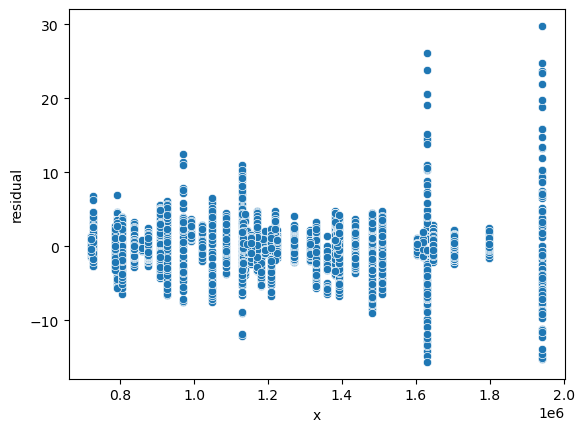

In [30]:
sns.scatterplot(data=residuals, x='x', y='residual')

<Axes: xlabel='y', ylabel='residual'>

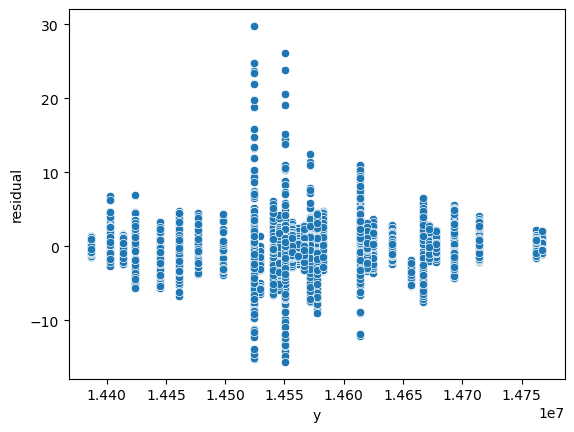

In [31]:
sns.scatterplot(data=residuals, x='y', y='residual')

<Axes: xlabel='Irrigation_pumping', ylabel='residual'>

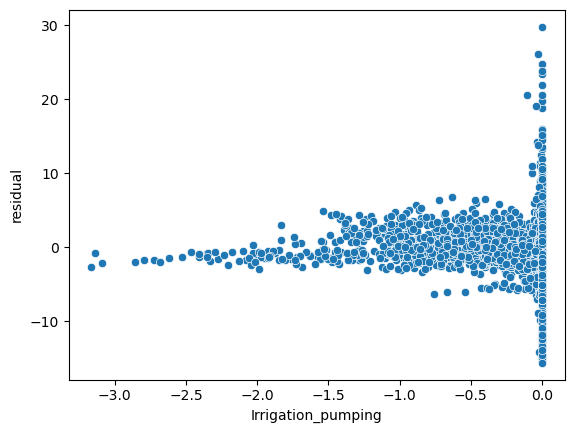

In [32]:
sns.scatterplot(data=residuals, x='Irrigation_pumping', y='residual')

## Linear Model from Sklearn

In [33]:
# ridge = RidgeCV(alphas=(10, 1, 0.1, 0.01, 0.001))
# ridge.fit(X_train, y_train)
# ridge_results = pd.DataFrame({'feature':X_train.columns, 'coeff': ridge.coef_})
# ridge_r2 = ridge.score(X_train, y_train)
# ridge_r2_adj = 1 - (1-ridge_r2) * (len(y_train)-1)/(len(y_train)-X.shape[1]-1)
# print("R^2:", ridge_r2)
# print("R^2 Adj:", ridge_r2_adj)
# print("Alpha:", ridge.alpha_)

## Model Evaluation

In [34]:
# removing segments of the river with low counts